In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
%matplotlib inline
%run "C:\Users\anasofiaccruz\Desktop\cingulate_silencing_repo\general_purpose_functions.ipynb"
%run "C:\Users\anasofiaccruz\Desktop\cingulate_silencing_repo\Latency_and_time_functions.ipynb"

#### <font color='darkorange'> Read the data

In [2]:
csv_file_path='C:/Users/anasofiaccruz/Desktop/Optogenetics processed data/no_outliers_no_baseline.csv'
runs = pd.read_csv(csv_file_path)

#### <font color='darkorange'> Histograms, cumulative distributions and qq plots within group

<Figure size 1800x1200 with 0 Axes>

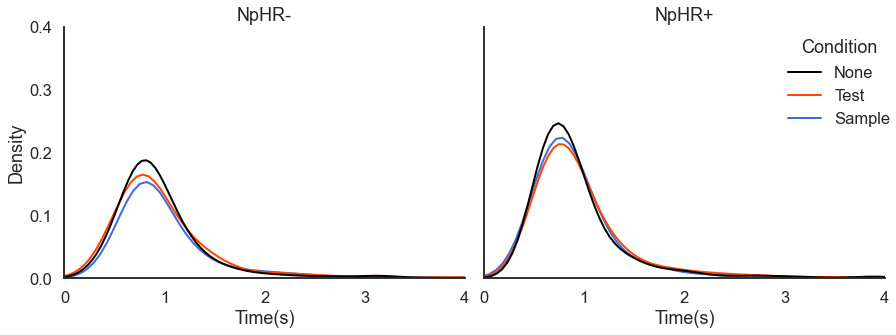

In [3]:
a = plot_latency_distributions_within_group(runs,
                                            'kde', 
                                            'time_in_cp',
                                            ['black','orangered','royalblue', ])
a.set(xlim=[0,4], ylim=[0,0.4], xlabel='Time(s)', xticks=range(0,5,1), xticklabels=range(0,5,1))

<Figure size 1800x1200 with 0 Axes>

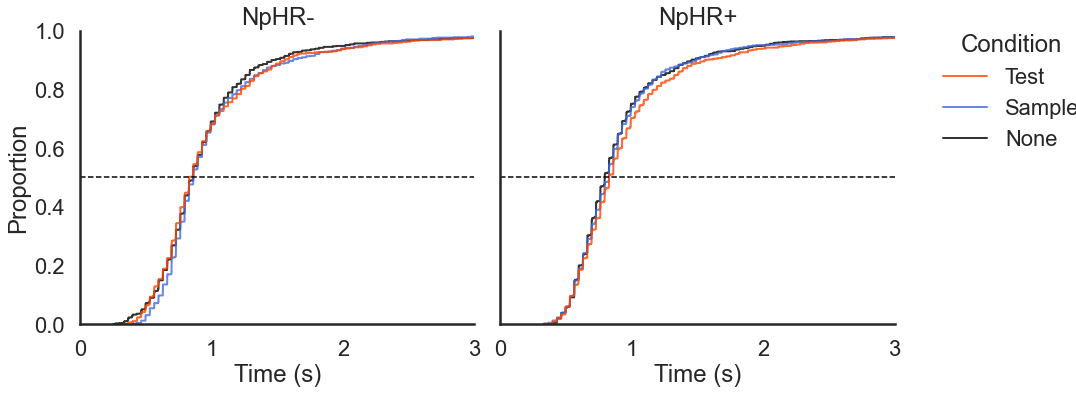

In [4]:
 g = plot_cumulative_distributions_within_group(runs, 'time_in_cp')
# subplot specs
axes = g.axes.flatten()
xticks = range(0,4)
xlim = [0,3]

axes[0].set(title="NpHR-", xlabel='Time (s)', xlim=xlim, xticks=xticks, xticklabels=xticks)
axes[0].axhline(0.5, linestyle='dashed', c='black', linewidth=1.5)
axes[1].set(title="NpHR+", xlabel='Time (s)', xlim=xlim, xticks=xticks, xticklabels=xticks)
axes[1].axhline(0.5, linestyle='dashed', c='black', linewidth=1.5)

(0.0, 2.0)

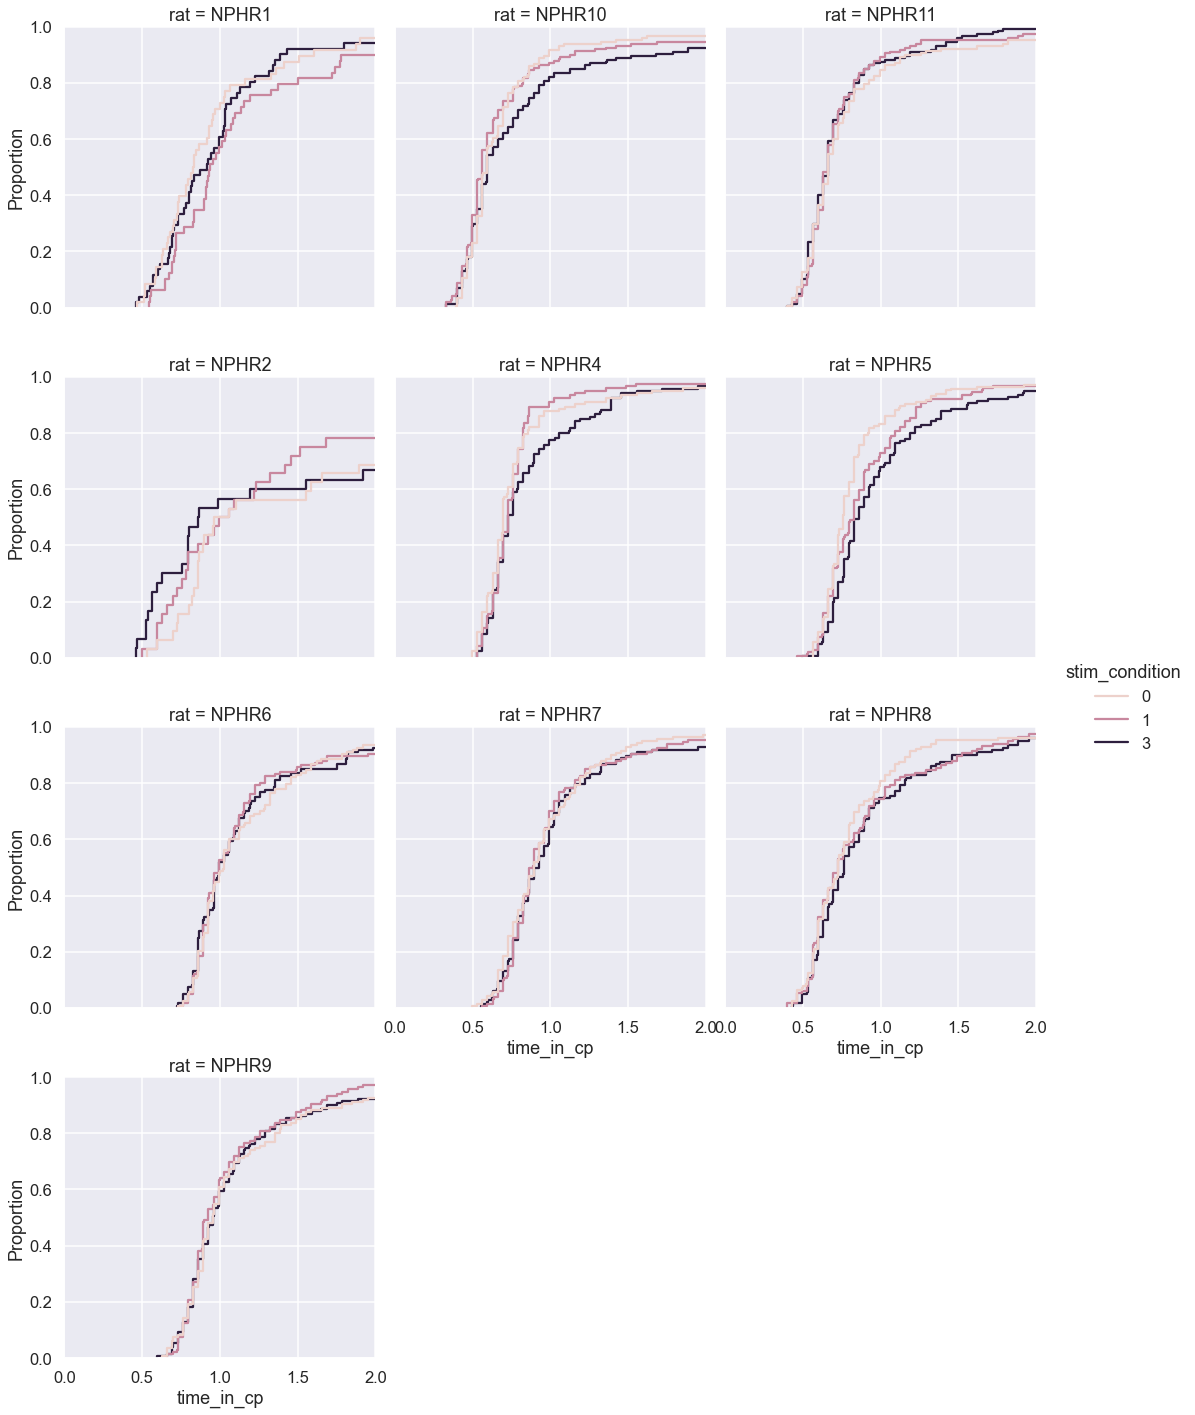

In [19]:
sns.displot(kind='ecdf', col='rat', col_wrap=3, 
             x='time_in_cp', hue='stim_condition', data=nphrs)
plt.xlim([0,2])

#### Are the distributions significantly influenced by condition and group?
###### To do this we will use an inverse transformation of the latency variable, previously calculated. Below we can see their distributions. Although it is clearly not guassian, the skewness and kurtosis (below) decreased quite a lot. I will resort to a linear mixed model to account for the dependency of data within conditions and check afterwards the assumptions of the model.

time_in_cp: skew=5.816469332467349, kurtosis=50.37492630373265
inv_time_in_cp: skew=0.4363811109786186, kurtosis=1.0932100226034942


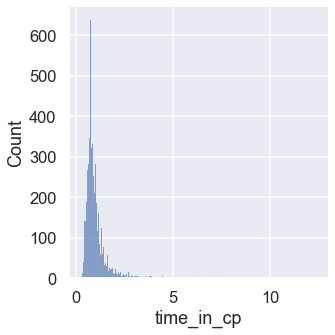

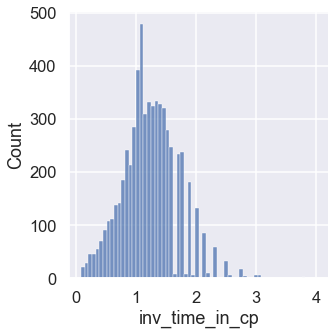

In [5]:
check_variables_distribution_parameters(runs, 'time_in_cp')
check_variables_distribution_parameters(runs, 'inv_time_in_cp')

In [64]:
nphrs=runs[runs['group']=='NPHR']

In [65]:
comparisons=pd.DataFrame()

In [71]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
mdf = smf.mixedlm("inv_time_in_cp ~ C(stim_condition)", 
                 data=nphrs, groups=nphrs["rat"], re_formula='C(stim_condition)').fit(reml=False)
print(mdf.summary())

                            Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            inv_time_in_cp
No. Observations:             3467               Method:                        ML            
No. Groups:                   10                 Scale:                         0.1560        
Min. group size:              94                 Log-Likelihood:                -1724.3416    
Max. group size:              440                Converged:                     Yes           
Mean group size:              346.7                                                           
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            1.227    0.072 17.059 0.00

C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [70]:
y_predict = mdf.fittedvalues
y=nphrs['inv_time_in_cp']

RMSE = np.sqrt(((y-y_predict)**2).values.mean())

model_type='random_intercept + random_slope'
comparisons.loc[model_type, 'rmse']=RMSE
comparisons.loc[model_type, 'aic']=mdf.aic
print(comparisons)

                                     rmse          aic
random intercept                 0.394159  3468.683167
random_intercept                 0.395072  3465.038989
random_intercept + random_slope  0.394159  3468.683167


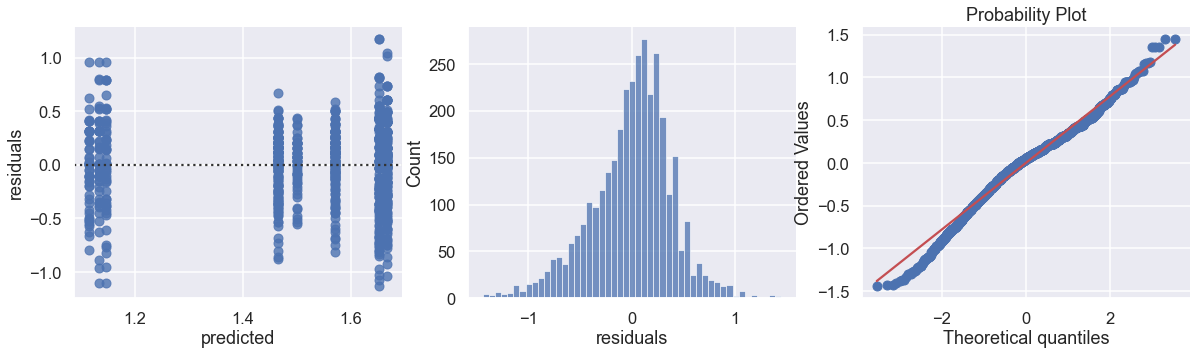

In [37]:
check_linear_model_assumptions(mdf, nphrs)

In [5]:
time_medians = runs.groupby(['group', 'rat', 'stim_condition','session_nr'])['time_in_cp', 'inv_time_in_cp'].median()
time_medians = time_medians.reset_index()
time_medians.to_csv('C:/Users/anasofiaccruz/Desktop/Optogenetics processed data/time_in_cp_medians.csv')

<ipython-input-5-1732b2c1b1ca>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  time_medians = runs.groupby(['group', 'rat', 'stim_condition','session_nr'])['time_in_cp', 'inv_time_in_cp'].median()


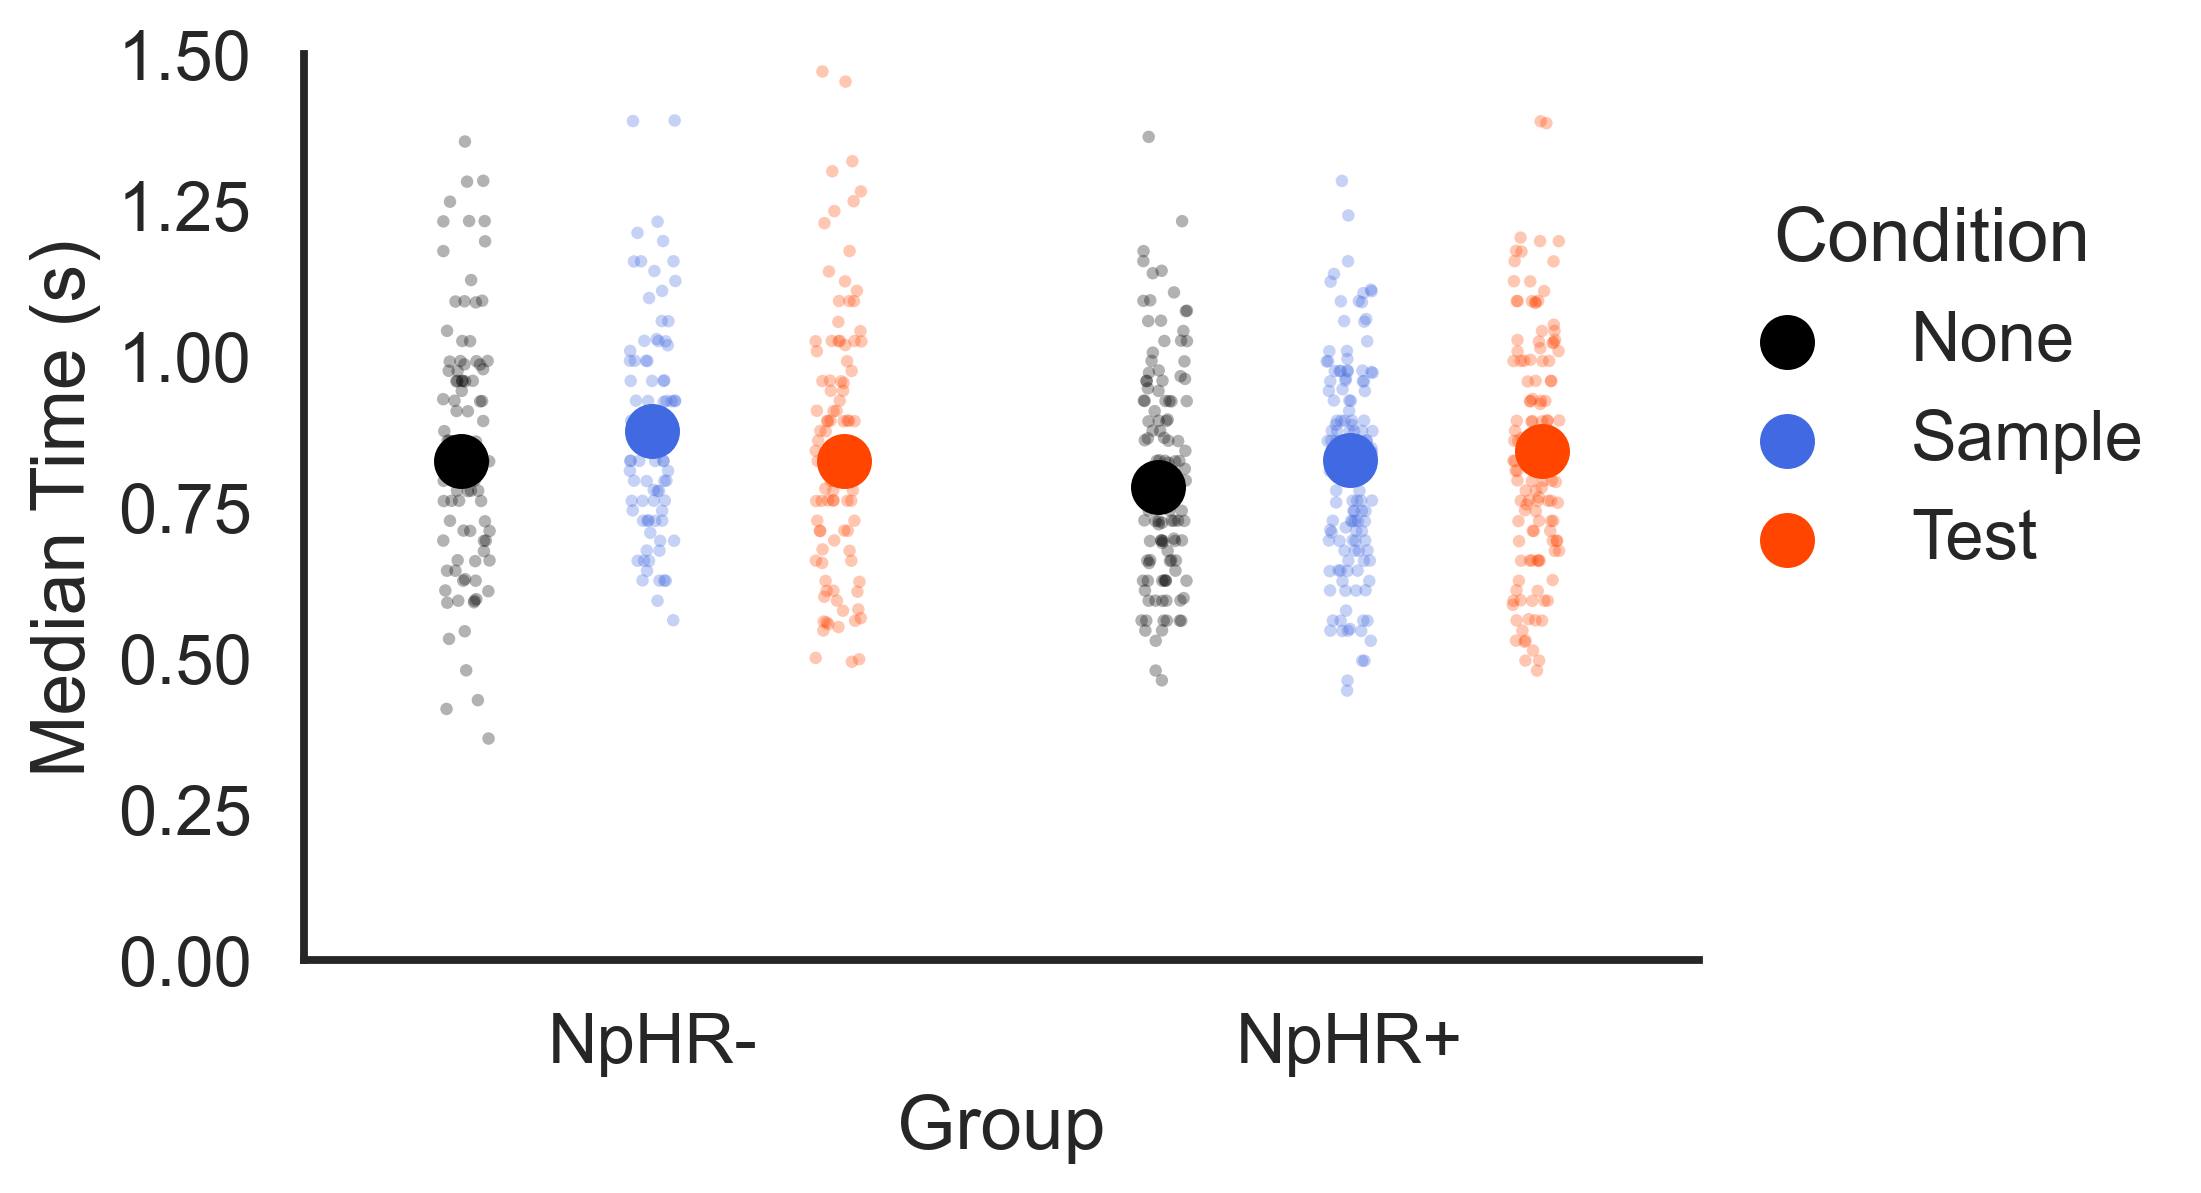

In [44]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)
g=sns.pointplot(
             data=time_medians, 
             x='group',
             y='time_in_cp', 
             hue=time_medians['stim_condition'].map({0:'None', 1:'Sample', 3:'Test'}), 
             dodge=.55, jitter=True, palette=['black', 'royalblue', 'orangered'], 
             hue_order=['None','Sample','Test'],estimator=np.median, ci=None,
             join=False, legend=False, marker='d')

sns.stripplot(data=time_medians, 
             x='group',
             y='time_in_cp', hue='stim_condition', hue_order=[0,1,3],
             dodge=True, palette=['black', 'royalblue', 'orangered'],
             s=3, alpha=.3)
g.set(ylim=[0,1.5], ylabel='Median Time (s)', xlabel='Group', xticks=[0,1], xticklabels=['NpHR-', 'NpHR+'])
plt.legend(labels=['None', 'Sample','Test'],frameon=False, title='Condition', bbox_to_anchor=[.97,.9])
sns.despine()

#### <font color='darkorange'> Histograms, cumulative distributions and qq plots within condition

<Figure size 1800x1200 with 0 Axes>

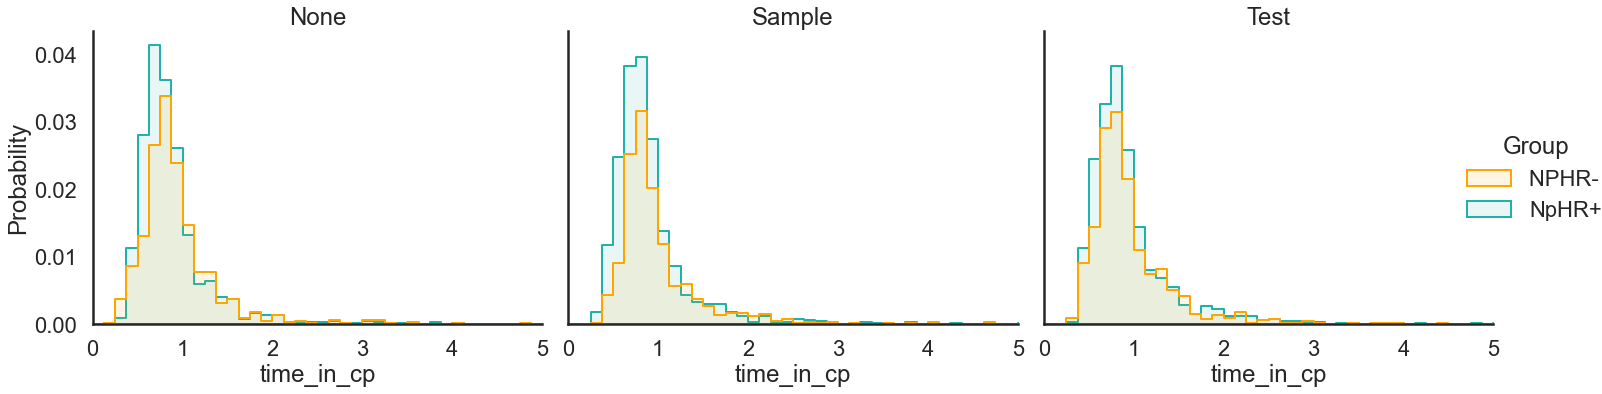

<Figure size 1800x1200 with 0 Axes>

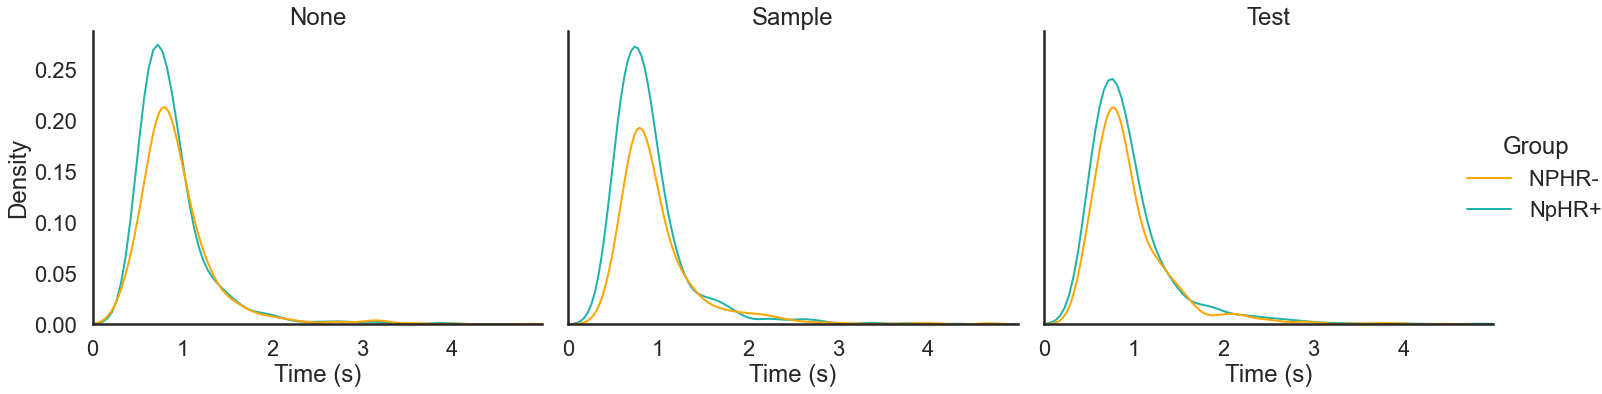

In [40]:
g = plot_latency_distributions_within_condition(runs,'hist','time_in_cp')
g.set(xlim=[0,5])
a = plot_latency_distributions_within_condition(runs,'kde','time_in_cp')
a.set(xlim=(0,5), xticks=range(0,5,1), xticklabels=range(0,5,1), xlabel='Time (s)')

<Figure size 1800x1200 with 0 Axes>

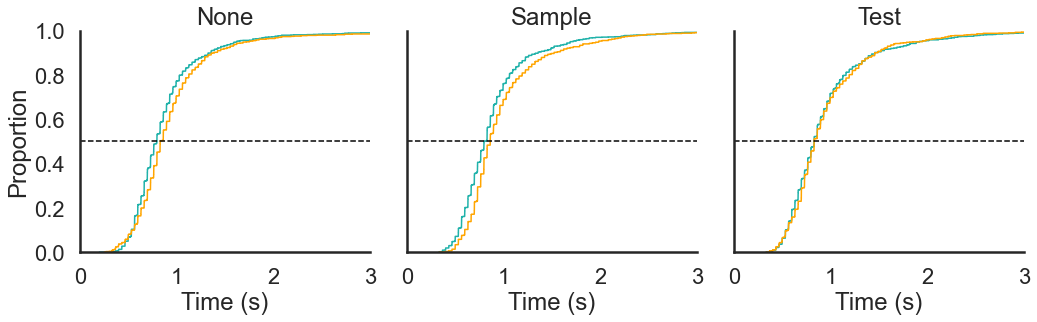

In [44]:
g = plot_cumulative_distributions_within_condition(runs, 'time_in_cp')
g.set(xlabel='Time (s)', xlim=[0,3], xticks=range(0,4,1), xticklabels=range(0,4))

#### <font color='darkorange'>  Inference testing on time in cp distributions within conditions

In [10]:
ctrls, nphrs=subidivide_by_group_and_condition(runs)

In [11]:
a = [ctrls['None'], ctrls['Sample'], ctrls['Test']]
b = [nphrs['None'], nphrs['Sample'], nphrs['Test']]
results = inference_testing_mannwhitneyu(a,b,'time_in_cp')
results

,a_group,b_group,a_condition,b_condition,a_outcome,b_outcome,u,p
0,CTRL,NPHR,0.0,0.0,1.0,1.0,601511.0,1.384571e-04
1,CTRL,NPHR,1.0,1.0,1.0,1.0,527052.5,7.409282e-07
2,CTRL,NPHR,3.0,3.0,1.0,1.0,550454.5,2.230343e-01
